In [1]:
from sys import argv
import warnings
from datetime import datetime
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import mplfinance        as mpf
warnings.filterwarnings('ignore')

In [2]:
asset = "btcusdt".upper()

df = pd.read_csv(f"./data/{asset}/{asset}-1m.csv", parse_dates=True, index_col="timestamp")
df = df.rename(columns={"op": "Open", "hi": "High", "lo":"Low", "cl":"Close", "volume": "Volume"})

df

,Open,High,Low,Close,Volume
timestamp,,,,,
2017-08-17 04:00:00+00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00+00:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00+00:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00+00:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00+00:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2022-09-10 08:19:00+00:00,21313.24,21328.01,21309.41,21326.15,165.289480
2022-09-10 08:20:00+00:00,21326.75,21350.00,21325.37,21348.74,209.965260
2022-09-10 08:21:00+00:00,21348.74,21351.40,21328.66,21330.08,269.798810


<AxesSubplot:>

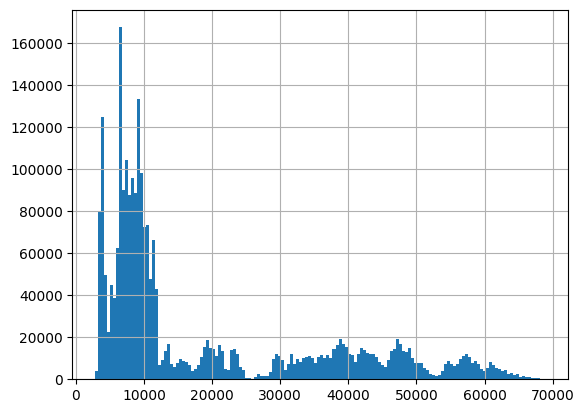

In [3]:
df['Close'].hist(bins=150)

<AxesSubplot:xlabel='timestamp'>

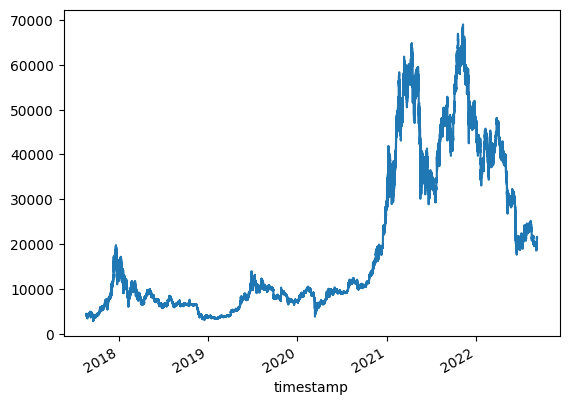

In [4]:
df['Close'].plot()

In [5]:
#size = 50000
#temp_df = df.iloc[-size:]
temp_df = df

#temp_df

In [6]:
# Geometric Brownian motion generator
def gbm(mu, sigma, x0, n, dt):
    step = np.exp( (mu - sigma**2 / 2) * dt ) * np.exp( sigma * np.random.normal(0, np.sqrt(dt), (1, n)))
    return x0 * step.cumprod()

<AxesSubplot:>

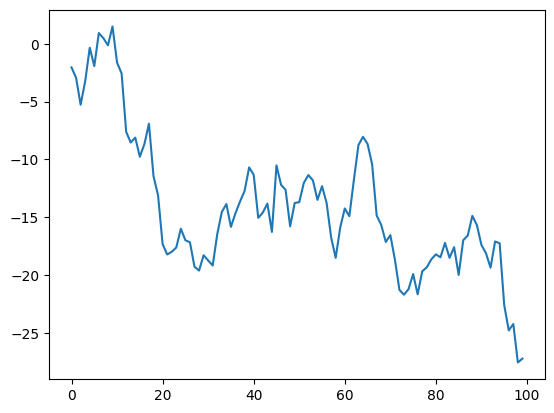

In [9]:
# Simple GBM exp

mu    = 1.5  # дундаж
sigma = 1.9  # хазайлт
x0    = 1.0  # эхлэх утга
n     = 100  # цувааны тоо
dt    = 1.5 # алхам

series = gbm(mu, sigma, x0, n, dt)
log_series = np.log(series)

series_df = pd.DataFrame()
series_df['val'] = log_series

series_df['val'].plot()

In [10]:
# Estimate mu just from the series end-points
# Note this is for a linear drift-diffusion process, i.e. the log of GBM
def simple_estimate_mu(series):
    x0 = series[0]
    T  = len(series)*dt
    return (series[-1] - x0)/T

# Use all the increments combined (maximum likelihood estimator)
# Note this is for a linear drift-diffusion process, i.e. the log of GBM
def incremental_estimate_mu(series):
    T     = len(series)*dt
    ts    = np.linspace(dt, T, len(series))
    total = (1.0 / dt) * (ts**2).sum()
    return (1.0 / total) * (1.0 / dt) * ( ts * series ).sum()

# This just estimates the sigma by its definition as the infinitesimal variance (simple Monte Carlo)
# Note this is for a linear drift-diffusion process, i.e. the log of GBM
# One can do better than this of course (MLE?)
def estimate_sigma(series):
    return np.sqrt( ( np.diff(series)**2 ).sum() / (len(series) * dt) )

# Estimator helper
all_estimates0 = lambda s: (simple_estimate_mu(s), incremental_estimate_mu(s), estimate_sigma(s))

# Since log-GBM is a linear Ito drift-diffusion process (scaled Wiener process with drift), we
# take the log of the realizations, compute mu and sigma, and then translate the mu and sigma
# to that of the GBM (instead of the log-GBM). (For sigma, nothing is required in this simple case).
def gbm_drift(log_mu, log_sigma):
    return log_mu + 0.5 * log_sigma**2

# Translates all the estimates from the log-series
def all_estimates(es):
    lmu1, lmu2, sigma = all_estimates0(es)
    return gbm_drift(lmu1, sigma), gbm_drift(lmu2, sigma), sigma

In [11]:
#temp_df = df.iloc[-50000:]

n = 10000 # group size
m = 300  # overlap size

s     = [np.log(temp_df['Close'].iloc[i:i+n]) for i in range(0, len(temp_df), n-m)]
e     = np.array([all_estimates(si) for si in s])
avgs  = np.mean(e, axis=0)

print(f"mu1={avgs[0]}, mu2={avgs[1]}, sigma={avgs[2]}")

mu1=9.350294438827723e-07, mu2=0.0009524817478662158, sigma=0.0009522209389721777


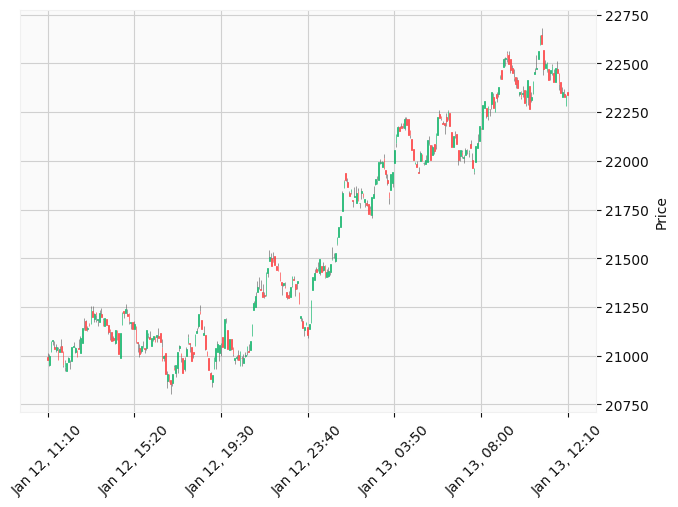

In [30]:
# Generate series which imitiates btcusdt behaviour

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
x0            = 21000.0
series_len    = 1500

series_df = pd.DataFrame()
series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

#series_df['val'].plot()

# OHLCV conversion

timeframe = 5
df_ = pd.DataFrame()
df_['price'] = series_df['val']

start_dt = datetime.strptime("12/1/2020 11:12:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 1700
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=False)

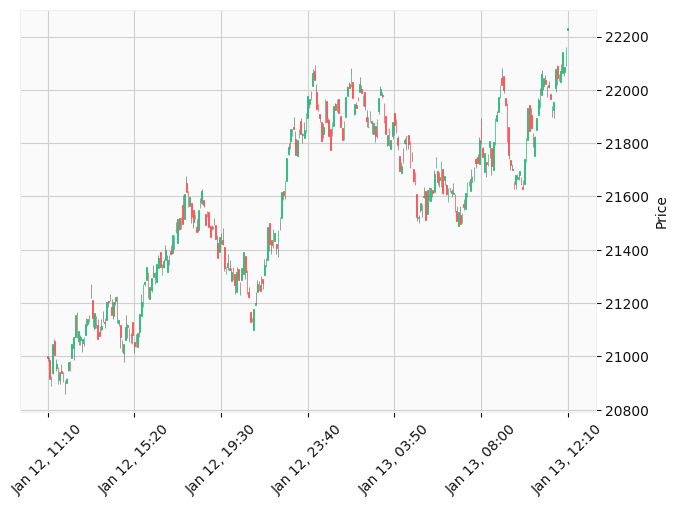

In [31]:
# Generate series which imitiates btcusdt behaviour

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
x0            = 21000.0
series_len    = 1500

series_df = pd.DataFrame()
series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

#series_df['val'].plot()

# OHLCV conversion

timeframe = 5
df_ = pd.DataFrame()
df_['price'] = series_df['val']

start_dt = datetime.strptime("12/1/2020 11:12:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 1700
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=False)

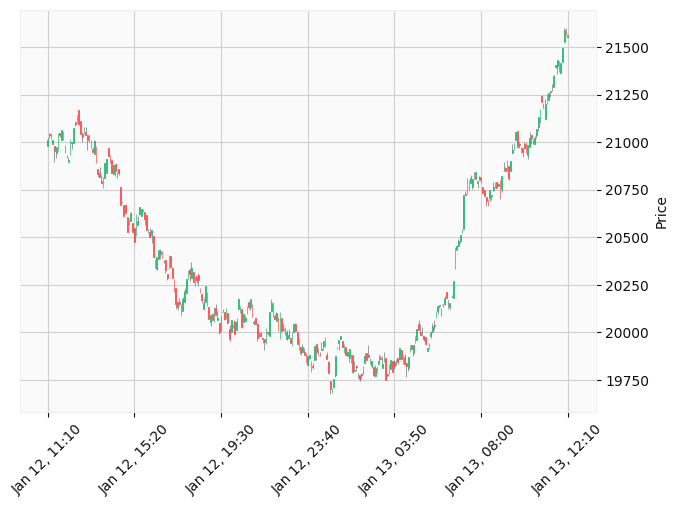

In [32]:
# Generate series which imitiates btcusdt behaviour

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
x0            = 21000.0
series_len    = 1500

series_df = pd.DataFrame()
series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

#series_df['val'].plot()

# OHLCV conversion

timeframe = 5
df_ = pd.DataFrame()
df_['price'] = series_df['val']

start_dt = datetime.strptime("12/1/2020 11:12:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 1700
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=False)

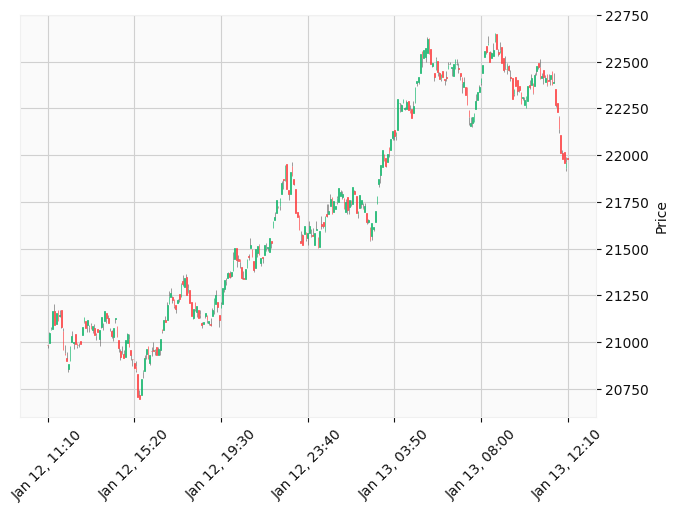

In [33]:
# Generate series which imitiates btcusdt behaviour

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
x0            = 21000.0
series_len    = 1500

series_df = pd.DataFrame()
series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

#series_df['val'].plot()

# OHLCV conversion

timeframe = 5
df_ = pd.DataFrame()
df_['price'] = series_df['val']

start_dt = datetime.strptime("12/1/2020 11:12:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 1700
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=False)

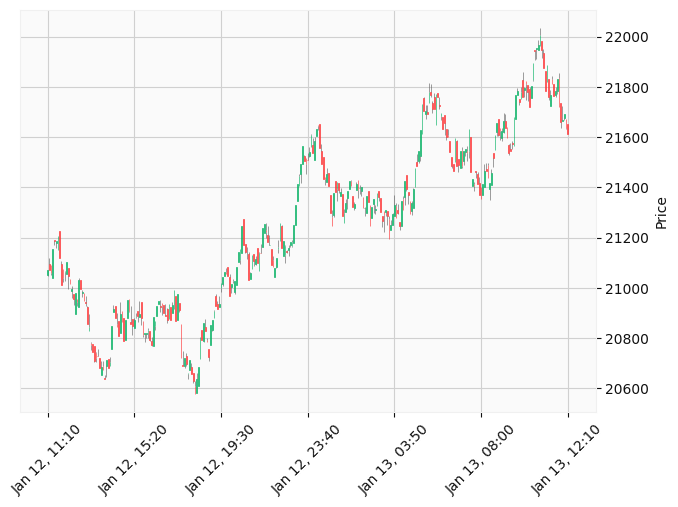

In [34]:
# Generate series which imitiates btcusdt behaviour

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
x0            = 21000.0
series_len    = 1500

series_df = pd.DataFrame()
series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

#series_df['val'].plot()

# OHLCV conversion

timeframe = 5
df_ = pd.DataFrame()
df_['price'] = series_df['val']

start_dt = datetime.strptime("12/1/2020 11:12:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 1700
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=False)

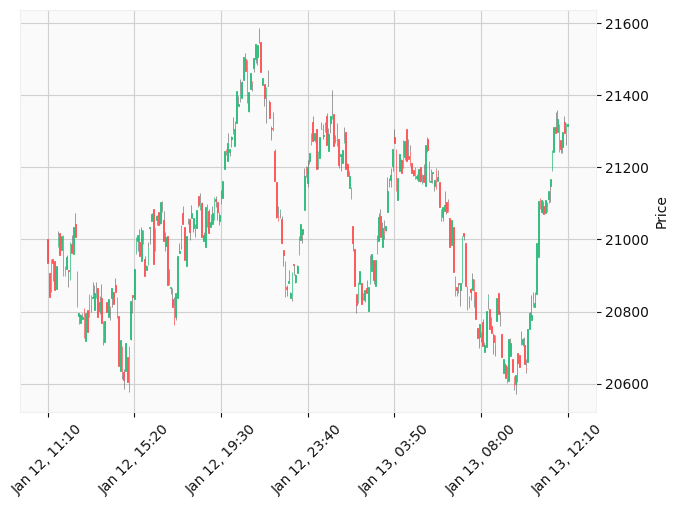

In [35]:
# Generate series which imitiates btcusdt behaviour

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
x0            = 21000.0
series_len    = 1500

series_df = pd.DataFrame()
series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

#series_df['val'].plot()

# OHLCV conversion

timeframe = 5
df_ = pd.DataFrame()
df_['price'] = series_df['val']

start_dt = datetime.strptime("12/1/2020 11:12:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 1700
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=False)

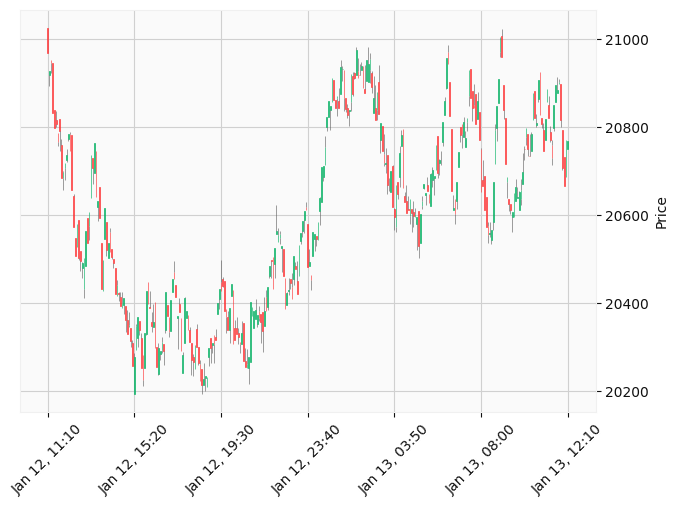

In [36]:
# Generate series which imitiates btcusdt behaviour

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
x0            = 21000.0
series_len    = 1500

series_df = pd.DataFrame()
series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

#series_df['val'].plot()

# OHLCV conversion

timeframe = 5
df_ = pd.DataFrame()
df_['price'] = series_df['val']

start_dt = datetime.strptime("12/1/2020 11:12:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 1700
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=False)

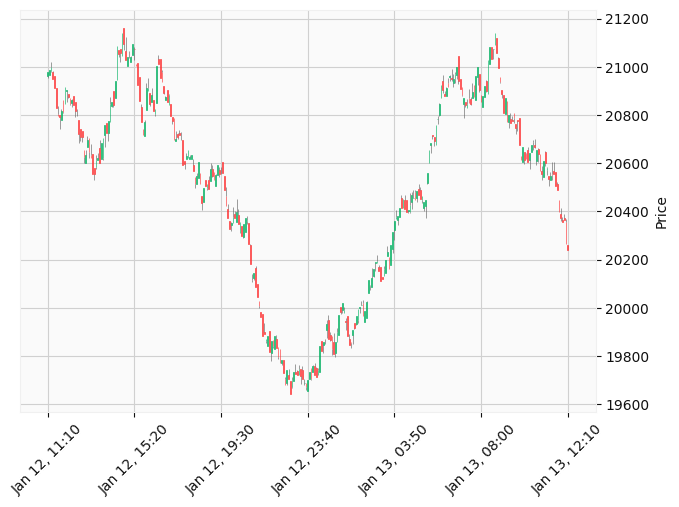

In [37]:
# Generate series which imitiates btcusdt behaviour

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
x0            = 21000.0
series_len    = 1500

series_df = pd.DataFrame()
series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

#series_df['val'].plot()

# OHLCV conversion

timeframe = 5
df_ = pd.DataFrame()
df_['price'] = series_df['val']

start_dt = datetime.strptime("12/1/2020 11:12:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 1700
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=False)

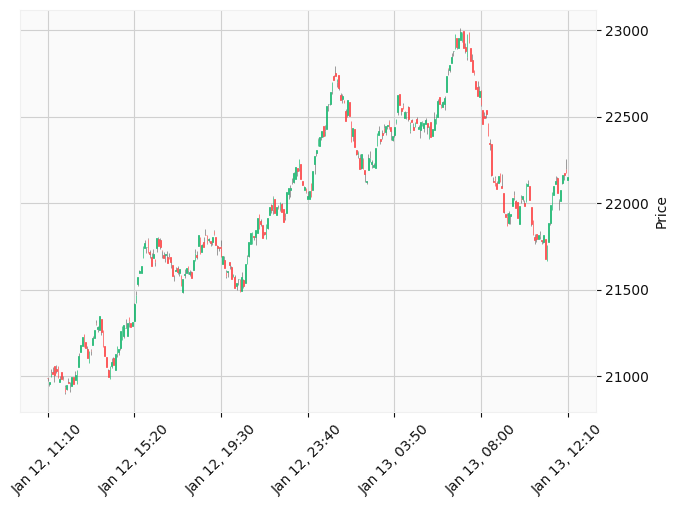

In [38]:
# Generate series which imitiates btcusdt behaviour

fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
x0            = 21000.0
series_len    = 1500

series_df = pd.DataFrame()
series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)

#series_df['val'].plot()

# OHLCV conversion

timeframe = 5
df_ = pd.DataFrame()
df_['price'] = series_df['val']

start_dt = datetime.strptime("12/1/2020 11:12:00.000000", "%d/%m/%Y %H:%M:%S.%f")
df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
df_ = df_.drop(['datetime'], axis=1)

df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

plot_len = 1700
mpf.plot(df_xm.iloc[-plot_len:], type='candle', style='yahoo', volume=False)

In [42]:
x0            = 18870    # initial price
fitted_mu     = avgs[0]
fitted_sigma  = avgs[2]
series_len    = 1500     # approx. 1 day
simulation_n  = 1000
mc_paths      = []
start_dt      = datetime.strptime("21/9/2022 08:55:00.000000", "%d/%m/%Y %H:%M:%S.%f")


for _ in range(0, simulation_n):
    series_df = pd.DataFrame()
    series_df['val'] = gbm(fitted_mu, fitted_sigma, x0, series_len, dt)
    timeframe = 5
    df_ = pd.DataFrame()
    df_['price'] = series_df['val']

    df_['datetime'] = [pd.to_datetime(start_dt+pd.DateOffset(minutes=offset)) for offset in range(0, len(df_))]

    df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
    df_ = df_.drop(['datetime'], axis=1)

    df_xm = df_['price'].resample(f"{timeframe}Min").ohlc()
    df_xm['Volume'] = 1.0 + np.random.sample(len(df_xm)) * 15
    df_xm = df_xm.rename(columns={"open": "Open", "high": "High", "low":"Low", "close":"Close"})

    mc_paths.append(df_xm['Close'])

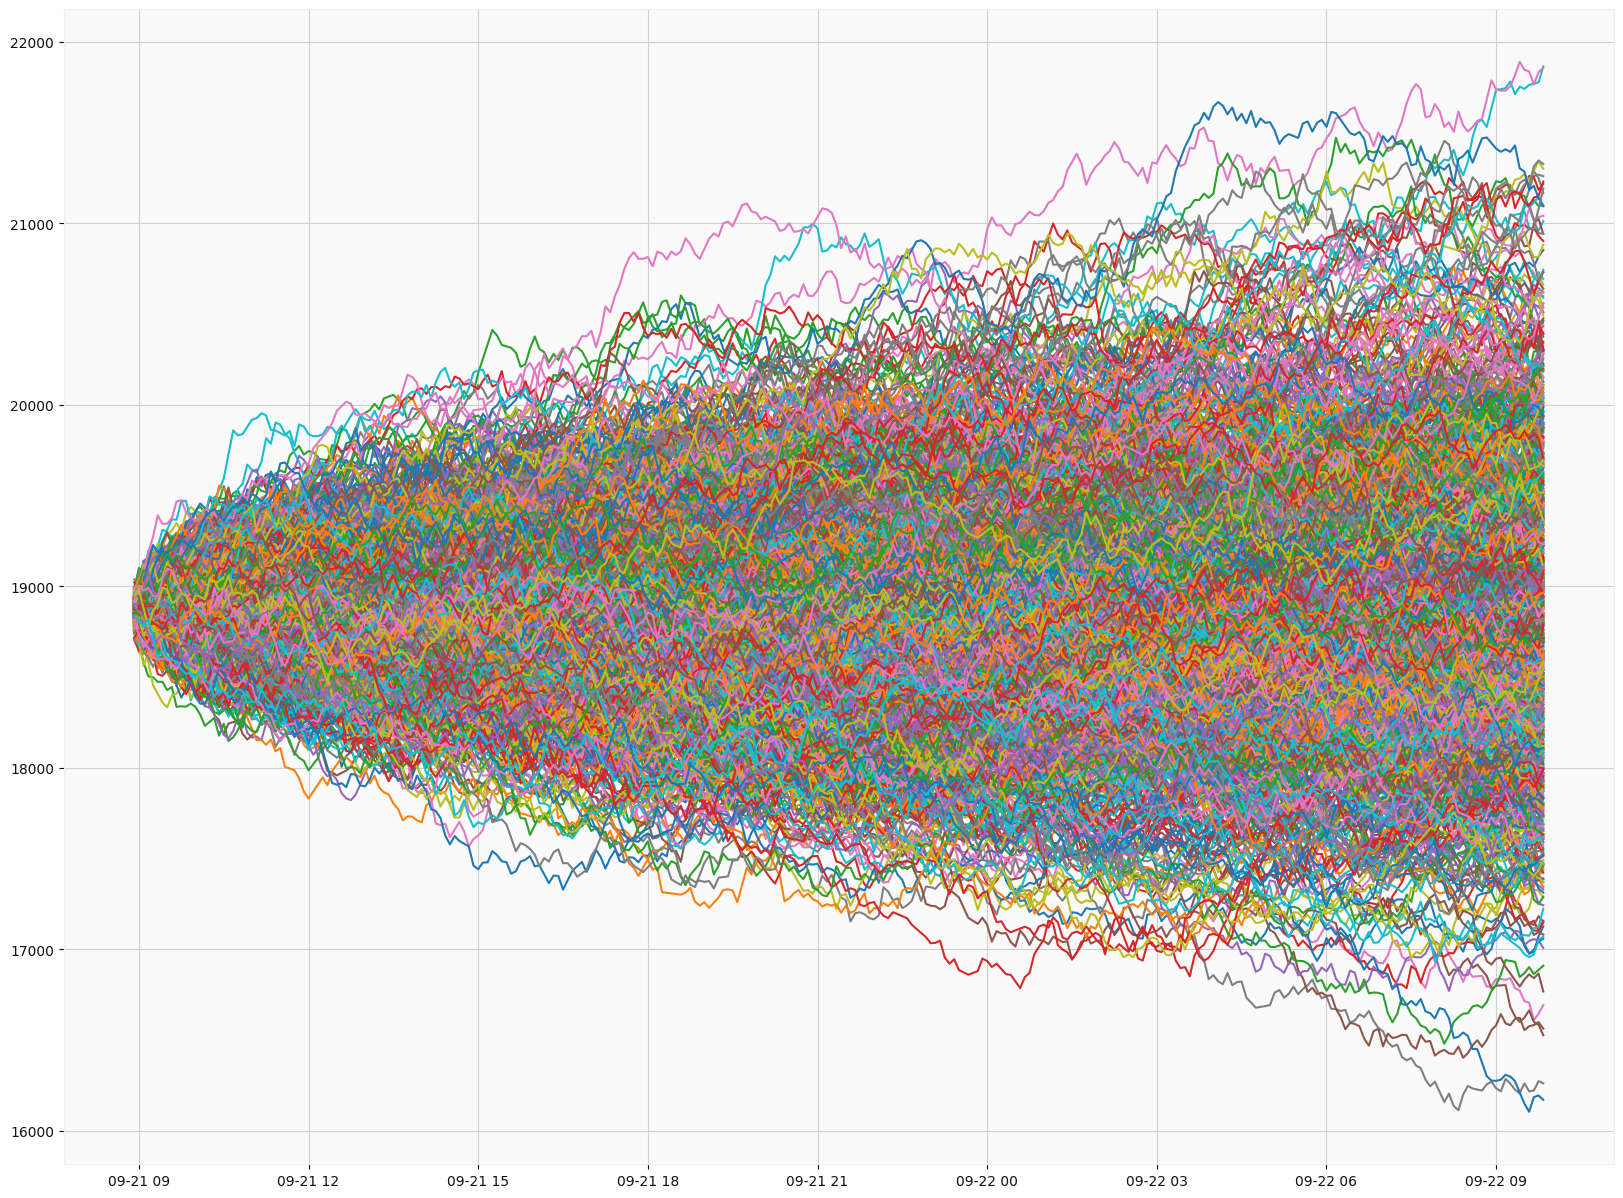

In [43]:
f, axs = plt.subplots(1, figsize=(20,15))
for series in mc_paths:
    axs.plot(series)